In [ ]:
import os, pathlib, tensorflow as tf
from tensorflow import keras

In [ ]:
DATA_DIR = "/content/drive/MyDrive/waste_dataset.zip"
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
import zipfile

# Define the directory to extract the dataset
dataset_dir = "/content/waste_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(DATA_DIR, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")

Dataset extracted to: /content/waste_dataset


# Data Preprocessing

In [ ]:
IMG_PATH = "/content/waste_dataset/waste_dataset/garbage_classification"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 10516 files belonging to 10 classes.
Using 8413 files for training.
Found 10516 files belonging to 10 classes.
Using 2103 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print(num_classes, "classes")

Classes: ['biological', 'cardboard', 'clothes', 'ewaste', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
10 classes


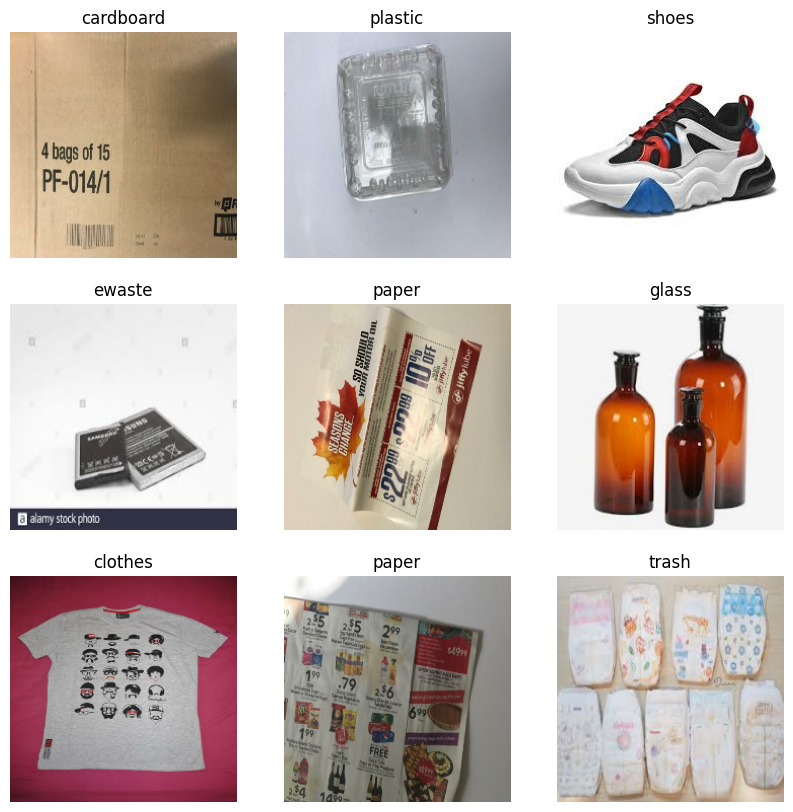

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.05),
], name="augment")

# Model Training

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base = EfficientNetB0(include_top=False,
                      weights="imagenet",
                      input_shape=(224, 224, 3))
base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5,
                                  restore_best_weights=True,
                                  monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 106ms/step - accuracy: 0.6908 - loss: 1.0502 - val_accuracy: 0.9220 - val_loss: 0.2752 - learning_rate: 0.0010
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9198 - loss: 0.2653 - val_accuracy: 0.9368 - val_loss: 0.2117 - learning_rate: 0.0010
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9424 - loss: 0.2042 - val_accuracy: 0.9453 - val_loss: 0.1863 - learning_rate: 0.0010
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9474 - loss: 0.1731 - val_accuracy: 0.9458 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9545 - loss: 0.1533 - val_accuracy: 0.9467 - val_loss: 0.1647 - learning_rate: 0.0010
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.9589 - loss: 0.1368 - val_accuracy: 0.9482 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9620 - 

In [ ]:
base.trainable = True

# Fine-tune from this layer onwards
for layer in base.layers:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tuned_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 248ms/step - accuracy: 0.9729 - loss: 0.0786 - val_accuracy: 0.9591 - val_loss: 0.1221 - learning_rate: 1.0000e-05
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 63s 241ms/step - accuracy: 0.9820 - loss: 0.0569 - val_accuracy: 0.9596 - val_loss: 0.1209 - learning_rate: 1.0000e-05
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.9846 - loss: 0.0486 - val_accuracy: 0.9639 - val_loss: 0.1165 - learning_rate: 1.0000e-05
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 63s 238ms/step - accuracy: 0.9854 - loss: 0.0435 - val_accuracy: 0.9624 - val_loss: 0.1138 - learning_rate: 1.0000e-05
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 63s 238ms/step - accuracy: 0.9892 - loss: 0.0378 - val_accuracy: 0.9634 - val_loss: 0.1114 - learning_rate: 1.0000e-05
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 63s 241ms/step - accuracy: 0.9892 - loss: 0.0339 - val_accuracy: 0.9629 - val_loss: 0.1116 - learning_rate: 1.0000e-05
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 24

# Model Testing

In [ ]:
# Get best epoch
best_epoch = tf.math.argmax(tuned_history.history["val_accuracy"]) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 9


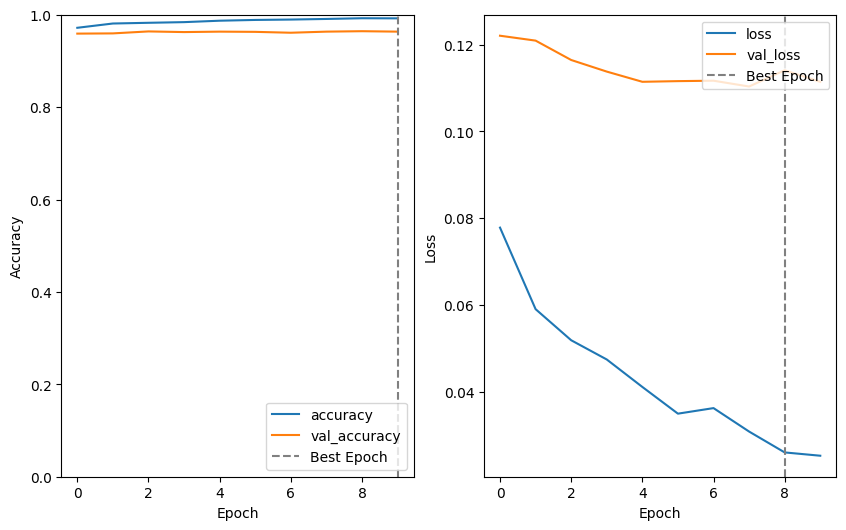

In [ ]:
# Plot history graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(tuned_history.history["accuracy"], label="accuracy")
plt.plot(tuned_history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.axvline(best_epoch, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(tuned_history.history["loss"], label="loss")
plt.plot(tuned_history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axvline(best_epoch - 1, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="upper right")

plt.show()

In [ ]:
import numpy as np

y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step


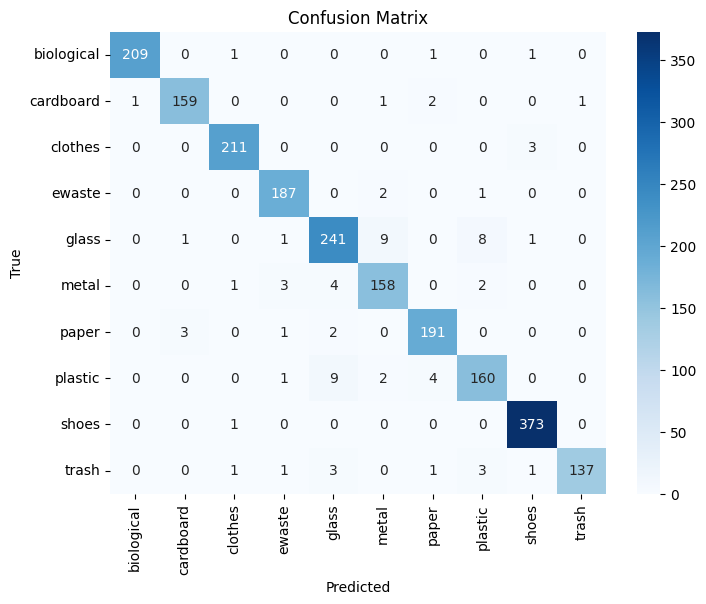

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Display the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

  biological       1.00      0.99      0.99       212
   cardboard       0.98      0.97      0.97       164
     clothes       0.98      0.99      0.98       214
      ewaste       0.96      0.98      0.97       190
       glass       0.93      0.92      0.93       261
       metal       0.92      0.94      0.93       168
       paper       0.96      0.97      0.96       197
     plastic       0.92      0.91      0.91       176
       shoes       0.98      1.00      0.99       374
       trash       0.99      0.93      0.96       147

    accuracy                           0.96      2103
   macro avg       0.96      0.96      0.96      2103
weighted avg       0.96      0.96      0.96      2103



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The predicted class is: clothes
Confidence is: 90.52%


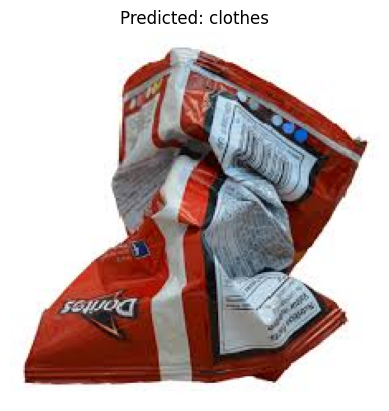

In [ ]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = '/content/chip_bag.jpg'
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make a prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]
prediction_confidence = predictions[0][predicted_class_index]

print(f"The predicted class is: {predicted_class_name}")
print(f"Confidence is: {(prediction_confidence * 100):.2f}%")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis("off")
plt.show()